In [1]:
import matplotlib.font_manager as fm
import seaborn as sns
import shap
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl

# ========== Set up custom font ==========
# Define the custom font
font_path = 'malgunsl.ttf'  # Use the Malgun Gothic SemiLight font

# Check if font exists
if os.path.exists(font_path):
    # Add the font to matplotlib's font manager
    font_prop = fm.FontProperties(fname=font_path)
    font_name = font_prop.get_name()
    print(f"Using custom font: {font_name}")
    
    # Set matplotlib default font
    plt.rcParams['font.family'] = font_prop.get_family()
    
    # For Korean text support
    plt.rcParams['axes.unicode_minus'] = False
    
    # Try to make font globally available to matplotlib
    from matplotlib import rc
    rc('font', family=font_prop.get_family())
else:
    print(f"Font file {font_path} not found. Using default font.")

# Set random seed for reproducibility
np.random.seed(42)



df = pd.read_csv('seafood_2022_class_and_distributed_method_ratio.csv')
df

Using custom font: Malgun Gothic


,수입화주,수출국,해외제조업소,수출업소,품명_대분류,품명_중분류,품명,총수량,총순중량,처리결과,...,수출국_대륙,수입화주_ratio,수출국_ratio,해외제조업소_ratio,수출업소_ratio,품명_대분류_ratio,품명_중분류_ratio,품명_ratio,수출국_대륙_ratio,유통방식_ratio
0,한스무역,스리랑카,SOUTH SEA FOOD,KMTCCMB0047185,어류,방어,참치방어,143,915.2,적합,...,Asia,0.0,0.036474,0.0,0.0,0.002001,0.003633,0.000000,0.001824,0.005612
1,용해수산,중국,"YANTAI HANSHENG AQUATIC FOODS CO., LTD.",HDFC17E4766580,두족류,낙지,낙지,1,3300.0,적합,...,Asia,0.0,0.001423,0.0,0.0,0.001402,0.001353,0.001353,0.001824,0.002163
2,용해수산,중국,"YANTAI HANSHENG AQUATIC FOODS CO., LTD.",HDFC17E4766580,기타,개불,개불,1,150.0,적합,...,Asia,0.0,0.001423,0.0,0.0,0.001188,0.000000,0.000000,0.001824,0.002163
3,주식회사 양지무역,중국,"YANTAI RUNHAI AQUATIC PRODUCTS CO.,LTD.",HDFC17E4766592A,두족류,낙지,낙지,1,2000.0,적합,...,Asia,0.0,0.001423,0.0,0.0,0.001402,0.001353,0.001353,0.001824,0.002163
4,주식회사 양지무역,중국,"YANTAI RUNHAI AQUATIC PRODUCTS CO.,LTD.",HDFC17E4766592A,기타,개불,개불,1,300.0,적합,...,Asia,0.0,0.001423,0.0,0.0,0.001188,0.000000,0.000000,0.001824,0.002163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469259,(주)신해무역,중국,"Shandong Haidu Ocean Product Co.,Ltd.",SOFPRWB22044571,두족류,오징어,오징어,8300,124500.0,적합,...,Asia,0.0,0.001423,0.0,0.0,0.001402,0.001833,0.002293,0.001824,0.002509
469260,(주)광천김,페루,CORPESMAR S.A.C,COSU6345238060,두족류,오징어,오징어,1100,22000.0,적합,...,South America,0.0,0.001134,0.0,0.0,0.001402,0.001833,0.002293,0.002221,0.002509
469261,네오푸드,미국,Aleutian Longline LLC - F/V Arctic Prowler,NAM5114609,어류,대구,대구,29,535.0,적합,...,North America,0.0,0.007358,0.0,0.0,0.002001,0.001560,0.000849,0.004723,0.002509
469262,네오푸드,미국,Aleutian Longline LLC - F/V U.S. Liberator,NAM5114609,어류,대구,대구,64,1185.0,적합,...,North America,0.0,0.007358,0.0,0.0,0.002001,0.001560,0.000849,0.004723,0.002509


In [2]:
# Create English translation dictionary for feature names
korean_to_english = {
    '수입화주': 'Importer',
    '수출국': 'Exporting_Country',
    '해외제조업소': 'Foreign_Manufacturer',
    '수출업소': 'Exporter',
    '품명_대분류': 'Product_Category',
    '품명_중분류': 'Product_Subcategory',
    '품명': 'Product_Name',
    '총수량': 'Total_Quantity',
    '총순중량': 'Total_Net_Weight',
    '유통방식': 'Distribution_Method',
    '검사종류_text': 'Inspection_Type',
    'year': 'Year',
    'month': 'Month',
    'week': 'Week',
    'year_month': 'Year_Month',
    'year_week': 'Year_Week',
    'season': 'Season',
    '수출국_대륙': 'Exporting_Continent',
    '수입화주_ratio': 'Importer_Ratio',
    '수출국_ratio': 'Exporting_Country_Ratio',
    '해외제조업소_ratio': 'Foreign_Manufacturer_Ratio',
    '수출업소_ratio': 'Exporter_Ratio',
    '품명_대분류_ratio': 'Product_Category_Ratio',
    '품명_중분류_ratio': 'Product_Subcategory_Ratio',
    '품명_ratio': 'Product_Name_Ratio',
    '수출국_대륙_ratio': 'Exporting_Continent_Ratio',
    '유통방식_ratio': 'Distribution_Method_Ratio',
    '처리결과': 'Result'
}

In [3]:
input_columns = df.columns.tolist()

input_columns.remove('처리결과')

output_column = '처리결과'


category_columns = ['수입화주', '수출국', '해외제조업소', '수출업소', '품명_대분류', '품명_중분류', '품명', '유통방식', '검사종류_text', 'year', 'month', 'week', 'year_month', 'year_week', 'season','수출국_대륙']

In [4]:
## '부적합' = 1, '적합' = 0

df['처리결과'] = df['처리결과'].replace('부적합', 1)
df['처리결과'] = df['처리결과'].replace('적합', 0)

In [5]:
# Split data by class
df_class_0 = df[df[output_column] == 0]
df_class_1 = df[df[output_column] == 1]

In [6]:
# Select random 88 samples from each class
sample_size = 88
df_class_0_sample = df_class_0.sample(sample_size, random_state=42)
df_class_1_sample = df_class_1.sample(sample_size, random_state=42)

# Combine the samples
df_balanced = pd.concat([df_class_0_sample, df_class_1_sample])
# Shuffle the combined data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
## load label encoder

from sklearn.preprocessing import LabelEncoder
import joblib

label_encoder = joblib.load('label_encoders.pkl')

df_balanced_encoded = df_balanced.copy()

label_encoder_dict = {}
for column in category_columns:
    if column in df_balanced.columns:
        label_encoder_dict[column] = label_encoder[column].transform(df_balanced_encoded[column])
        df_balanced_encoded[column] = label_encoder_dict[column]
        


In [8]:
## calculate shap values of df_1_encoded

X_selected  = df_balanced_encoded[input_columns]
y_selected  = df_balanced_encoded[output_column]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42, stratify=y_selected)

In [10]:
print("Creating KernelExplainer for voting_classifier_soft...")
# Use a smaller sample for KernelExplainer for computational efficiency
# Convert to numpy array for better compatibility with SHAP
X_train_np = X_train.values
X_test_np = X_test.values
feature_names = X_test.columns.tolist()

Creating KernelExplainer for voting_classifier_soft...


In [11]:
# 1. Load your saved models
import joblib
print("Loading saved models...")
dt = joblib.load('saved_models/decision_tree_model.pkl')
rf = joblib.load('saved_models/random_forest_model.pkl')
lr = joblib.load('saved_models/logistic_regression_model.pkl')
nb = joblib.load('saved_models/naive_bayes_model.pkl')
voting_clf_soft = joblib.load('saved_models/voting_classifier_soft.pkl')

Loading saved models...


In [12]:
import shap
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# Create a background dataset for the explainer - using k-means for efficiency
X_train_summary = shap.kmeans(X_train_np, 50)

# Define the predict function that returns probabilities for class 1
def model_predict(X):
    return voting_clf_soft.predict_proba(X)[:, 1]

# Create the explainer with the predict function
explainer = shap.KernelExplainer(model_predict, X_train_summary)

# Calculate SHAP values for test set (use subset for efficiency)
n_samples_to_explain = min(20, len(X_test))  # Limit to 20 samples for speed
test_sample = X_test_np[:n_samples_to_explain]
print(f"Calculating SHAP values for {n_samples_to_explain} samples (this may take a while)...")

# Calculate SHAP values
shap_values = explainer.shap_values(test_sample)

# Print shapes to debug
print(f"SHAP values shape: {np.array(shap_values).shape}")
print(f"Test sample shape: {test_sample.shape}")

Calculating SHAP values for 20 samples (this may take a while)...


  0%|          | 0/20 [00:00<?, ?it/s]

SHAP values shape: (20, 27)
Test sample shape: (20, 27)


In [13]:
feature_names

['수입화주',
 '수출국',
 '해외제조업소',
 '수출업소',
 '품명_대분류',
 '품명_중분류',
 '품명',
 '총수량',
 '총순중량',
 '유통방식',
 '검사종류_text',
 'year',
 'month',
 'week',
 'year_month',
 'year_week',
 'season',
 '수출국_대륙',
 '수입화주_ratio',
 '수출국_ratio',
 '해외제조업소_ratio',
 '수출업소_ratio',
 '품명_대분류_ratio',
 '품명_중분류_ratio',
 '품명_ratio',
 '수출국_대륙_ratio',
 '유통방식_ratio']

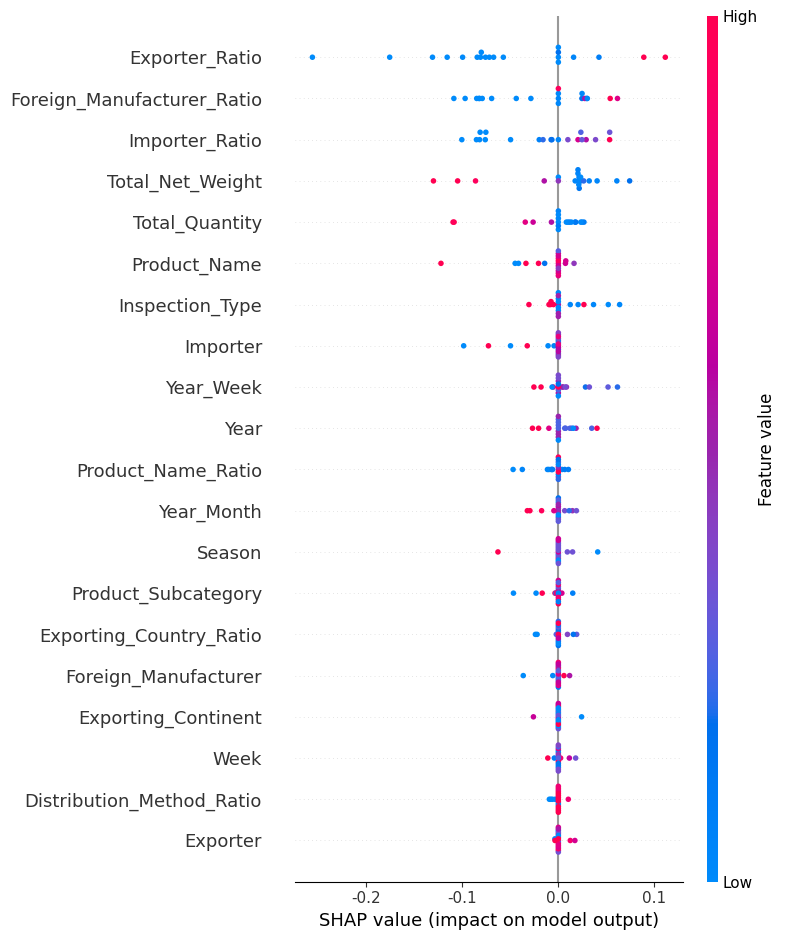

Successfully created summary plot


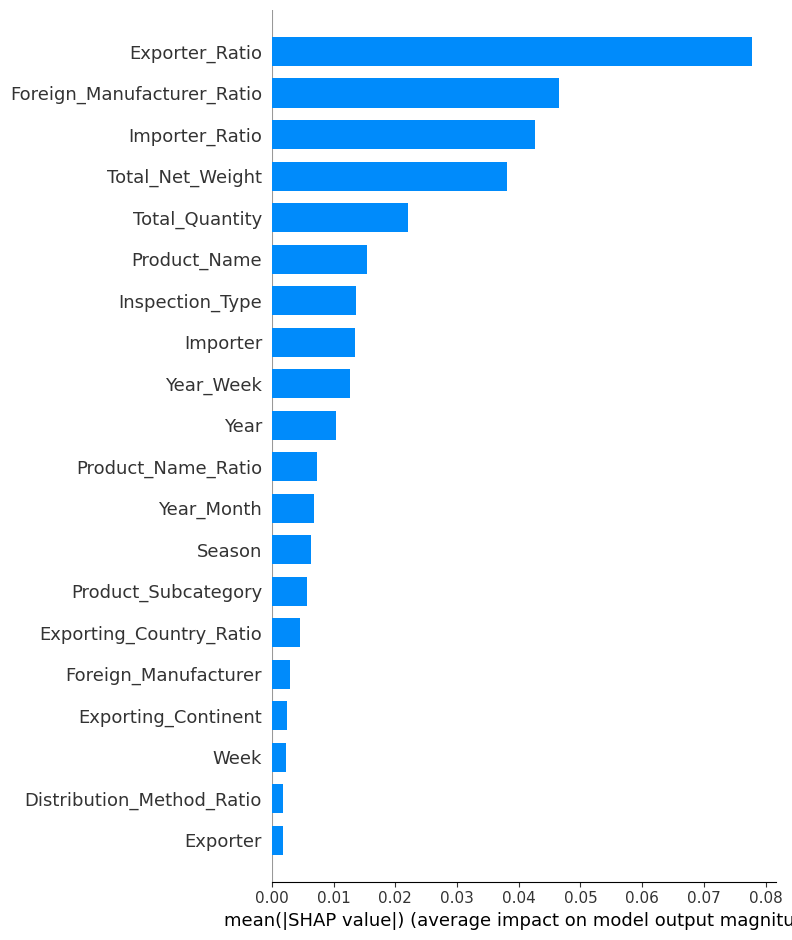

Successfully created bar plot
Successfully created force plot for sample 0
Successfully created force plot for sample 1
Successfully created force plot for sample 2
Successfully created force plot for sample 3
Successfully created force plot for sample 4


In [16]:
import matplotlib.pyplot as plt
import os
import matplotlib.font_manager as fm


## change feature names to English

feature_names = [korean_to_english.get(name, name) for name in feature_names]

# ========== Generate SHAP visualizations ==========

def create_figure(figsize=(12, 8)):
    fig = plt.figure(figsize=figsize)
    return fig

# Summary plot to show feature importance
create_figure(figsize=(14, 10))
try:
    # For KernelExplainer with a single output, shap_values is directly usable
    shap.summary_plot(shap_values, test_sample, feature_names=feature_names, max_display=20)
    plt.title("SHAP Feature Importance Summary", fontproperties=font_prop if os.path.exists(font_path) else None)
    plt.tight_layout()
    plt.savefig("shap_summary.png", dpi=300, bbox_inches='tight')
    print("Successfully created summary plot")
except Exception as e:
    print(f"Error creating summary plot: {e}")
finally:
    plt.close()

# Bar plot to show average impact on model output magnitude
create_figure(figsize=(14, 10))
try:
    shap.summary_plot(shap_values, test_sample, feature_names=feature_names, plot_type='bar', max_display=20)
    plt.title("SHAP Feature Importance (Bar Plot)", fontproperties=font_prop if os.path.exists(font_path) else None)
    plt.tight_layout()
    plt.savefig("shap_bar_importance.png", dpi=300, bbox_inches='tight')
    print("Successfully created bar plot")
except Exception as e:
    print(f"Error creating bar plot: {e}")
finally:
    plt.close()

# Force plot for a single instance
try:
    for i in range(min(5, len(test_sample))):
        # Create an individual force plot
        fig = create_figure(figsize=(20, 3))
        
        # For KernelExplainer with binary classification
        force_plot = shap.force_plot(
            explainer.expected_value,  # Base value
            shap_values[i],           # SHAP values for this instance
            test_sample[i],           # Feature values
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f"SHAP Force Plot for Sample {i} (Class: {y_test.iloc[i]})", 
                 fontproperties=font_prop if os.path.exists(font_path) else None)
        plt.tight_layout()
        plt.savefig(f"shap_force_sample_{i}.png", dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Successfully created force plot for sample {i}")
except Exception as e:
    print(f"Error creating force plots: {e}")


Successfully created waterfall plot for sample 0
Successfully created waterfall plot for sample 1
Successfully created waterfall plot for sample 2
Successfully created waterfall plot for sample 3
Successfully created waterfall plot for sample 4


<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

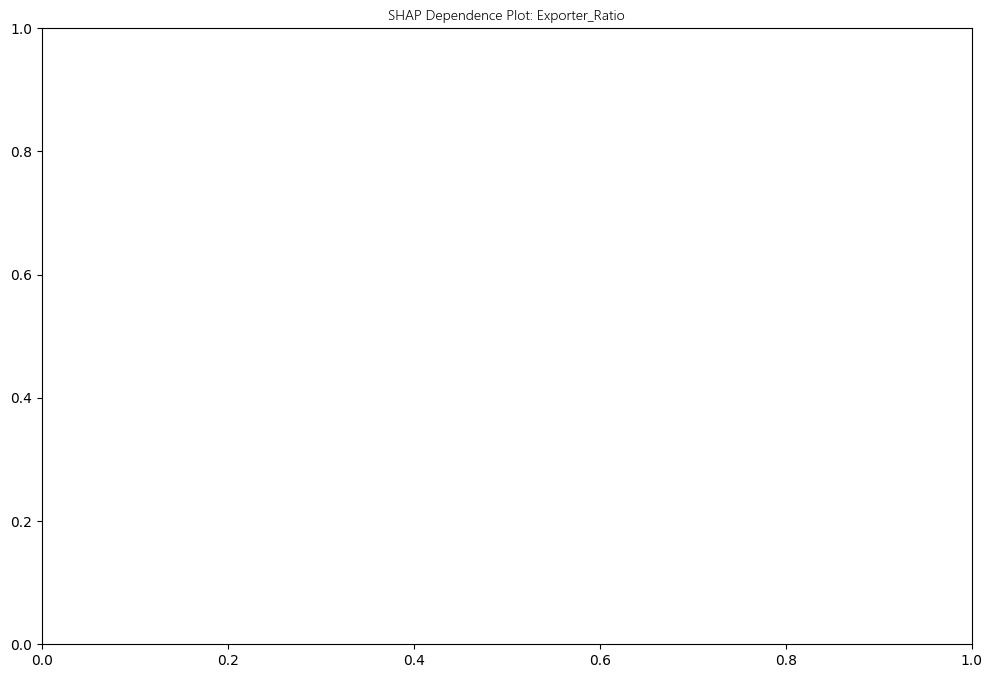

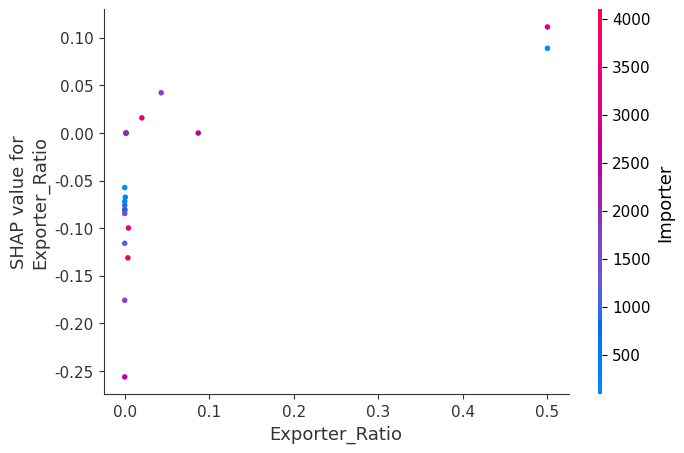

Successfully created dependence plot for Exporter_Ratio


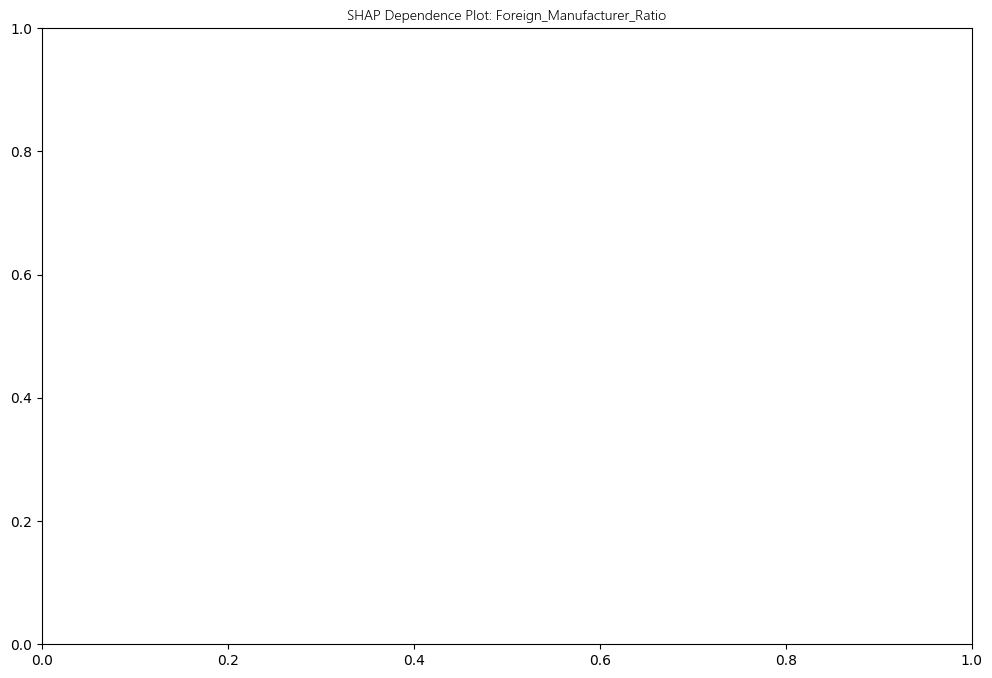

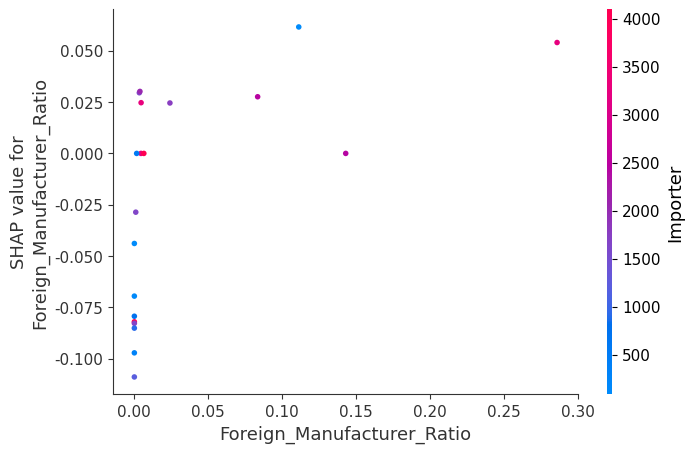

Successfully created dependence plot for Foreign_Manufacturer_Ratio
Successfully created feature importance ranking


In [17]:
# ========== Use shap.Explanation for more modern plots ==========

# Convert to SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values,
    base_values=np.repeat(explainer.expected_value, len(shap_values)),
    data=test_sample,
    feature_names=feature_names
)

# Usage example for waterfall plots:
try:
    for i in range(min(5, len(test_sample))):
        result_type = "Fail" if y_test.iloc[i] == 1 else "Pass"
        fig = create_figure(figsize=(12, 8))
        plt.title(f"SHAP Waterfall Plot for Sample {i} (Class: {result_type})", 
                 fontproperties=font_prop if os.path.exists(font_path) else None)
        shap.plots.waterfall(explanation[i], max_display=15, show=False)
        plt.tight_layout()
        plt.savefig(f"shap_waterfall_sample_{i}.png", dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Successfully created waterfall plot for sample {i}")
except Exception as e:
    print(f"Error creating waterfall plots with Explanation object: {e}")
    
    try:
        # Try an alternative approach for waterfall plots
        for i in range(min(5, len(test_sample))):
            result_type = "Fail" if y_test.iloc[i] == 1 else "Pass"
            fig = create_figure(figsize=(12, 8))
            plt.title(f"Feature Contributions for Sample {i} (Class: {result_type})", 
                     fontproperties=font_prop if os.path.exists(font_path) else None)
            
            # Sort values by magnitude for better visualization
            idx = np.argsort(-np.abs(shap_values[i]))
            sorted_values = shap_values[i][idx]
            sorted_features = [feature_names[j] for j in idx]
            
            # Plot horizontal bar chart of SHAP values
            y_pos = np.arange(min(15, len(sorted_features)))
            plt.barh(y_pos, sorted_values[:15], align='center')
            plt.yticks(y_pos, sorted_features[:15])
            plt.xlabel('SHAP Value (impact on model output)', 
                      fontproperties=font_prop if os.path.exists(font_path) else None)
            plt.tight_layout()
            plt.savefig(f"feature_contributions_sample_{i}.png", dpi=300, bbox_inches='tight')
            plt.close()
            print(f"Successfully created feature contribution plot for sample {i}")
    except Exception as e:
        print(f"Error creating alternative feature contribution plots: {e}")

# For dependence plots:
try:
    for i, idx in enumerate(top_indices[:2]):  # Just plot top 2 for brevity
        fig = create_figure(figsize=(12, 8))
        plt.title(f"SHAP Dependence Plot: {feature_names[idx]}", 
                 fontproperties=font_prop if os.path.exists(font_path) else None)
        shap.dependence_plot(
            idx,                 # Feature index
            shap_values,         # SHAP values
            test_sample,         # Feature values
            feature_names=feature_names,
            interaction_index="auto"
        )
        plt.tight_layout()
        plt.savefig(f"shap_dependence_{i+1}.png", dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Successfully created dependence plot for {feature_names[idx]}")
except Exception as e:
    print(f"Error creating dependence plots: {e}")

# For feature importance plot:
fig = create_figure(figsize=(12, 10))
plt.title('Feature Importance Based on SHAP Values', 
         fontproperties=font_prop if os.path.exists(font_path) else None)
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.xlabel('Mean |SHAP Value|', 
          fontproperties=font_prop if os.path.exists(font_path) else None)
plt.ylabel('Feature', 
          fontproperties=font_prop if os.path.exists(font_path) else None)
plt.tight_layout()
plt.savefig("feature_importance_ranking.png", dpi=300, bbox_inches='tight')
plt.close()
print("Successfully created feature importance ranking")